In [2]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
# Giannoulis, this is a test

            Timestamp      Wsp      TI  TI,detrend   MeanDir  MeanTrigDir  \
0 2004-10-01 00:00:00   9.9196  0.0181      0.0145  346.7130     346.7130   
1 2004-10-01 00:20:00   9.5073  0.0145      0.0116  346.9852     346.9852   
2 2004-10-01 00:30:00   9.5274  0.0210      0.0195  346.9152     346.9151   
3 2004-10-01 00:40:00   9.9498  0.0253      0.0195  346.3204     346.3204   
4 2004-10-01 00:50:00  10.2376  0.0151      0.0134  345.4185     345.4185   

   StdDir   MinDir   MaxDir  
0  0.8440  343.893  349.044  
1  0.6518  344.751  348.949  
2  0.7949  343.754  350.588  
3  0.7549  343.971  349.953  
4  0.6362  343.074  348.960  


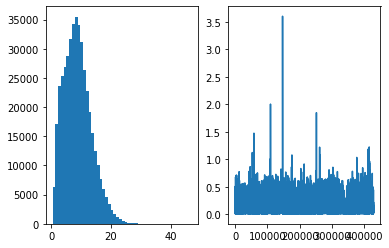

In [3]:
data_path = '../data/'
results_path = '../results/'

# load and print dataset
raw_data = pd.read_csv(data_path + 'HovsoreData_Sonic_100m_2004-2013.csv')
raw_data.head()
raw_data['Timestamp'] = pd.to_datetime(raw_data['Timestamp'], format='%Y%m%d%H%M')

filt_idx = ((raw_data["Wsp"] > 60) | (raw_data["Wsp"] < 0.05)) | ((raw_data["TI"] < 0.01) | (raw_data["TI"] > 4))
filtered_data = raw_data[~filt_idx]
filtered_data = filtered_data.dropna(axis=0)
filtered_data = filtered_data.reset_index(drop=True)
print(filtered_data.head(5))

# visualise dataset
# plt.plot(raw_data['Wsp'])
fig, ax = plt.subplots(1,2)
# ax[0].hist(raw_data["Wsp"][raw_data["Wsp"] < 60], 50)
# ax[1].plot(raw_data["TI"]) # outliers can be observed
ax[0].hist(filtered_data["Wsp"], 50)
ax[1].plot(filtered_data["TI"]) # outliers can be observed

plt.show()

# Fit joint distribution to wind speed, turbulence

In [4]:
# compute turbulence from sigmaU = TI * Wsp
filtered_data['sigmaWsp'] = filtered_data["TI"] * filtered_data["Wsp"]
filtered_data.head(3)

# fit weibull to wind speed : maximum likelihood method
Wsp0 = np.asarray(filtered_data["Wsp"])
# Wsp0 = Wsp0[Wsp0 < 60]
print(sum(np.isnan(Wsp0)))

mle_Weib = lambda theta : -np.sum(np.log( stats.weibull_min.pdf(Wsp0, loc=0, scale=theta[0], c=theta[1]) ))
Weibull_params = scipy.optimize.minimize(mle_Weib, [Wsp0.mean(), np.log(Wsp0).std()])
print(Weibull_params)
A_weibull = Weibull_params.x[0]
k_weibull = Weibull_params.x[1]

print("\nWeibull distribution:")
print(f"A:{A_weibull}")
print(f"k:{k_weibull}")

# fitted weibull distribution
Wsp_sort = np.sort(Wsp0)
pdf_weibull = stats.weibull_min.pdf(Wsp_sort, scale=A_weibull, c=k_weibull)

0
      fun: 1239279.5737238429
 hess_inv: array([[ 1.66014077e-04, -1.97192206e-05],
       [-1.97192206e-05,  8.73166638e-06]])
      jac: array([0., 0.])
  message: 'Optimization terminated successfully.'
     nfev: 45
      nit: 10
     njev: 15
   status: 0
  success: True
        x: array([9.98342566, 2.03255618])

Weibull distribution:
A:9.983425656103979
k:2.0325561802935543


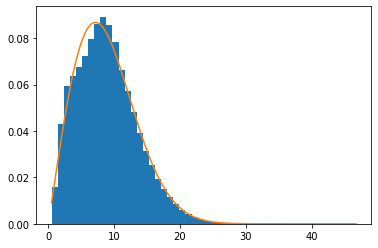

In [5]:
# Visualise fitted distribution
fig, ax = plt.subplots(1)
ax.hist(Wsp0, bins=50, density=True)
ax.plot(Wsp_sort, pdf_weibull)
plt.show()

In [6]:
# Fit conditional distribution to turbulence - bin data
WspBinEdges = np.arange(3.5, 32.5, 1)
WspBinCentres = .5 + WspBinEdges[:-1]

# initialise mean and std of turbulence for each bin
meanSigmaBinned = np.zeros_like(WspBinCentres)
stdSigmaBinned = np.zeros_like(WspBinCentres)

# find mean and std of turbulence (=sigmaU) in each bin
for i,val in enumerate(WspBinCentres):
    WspMask = (filtered_data["Wsp"] > WspBinEdges[i]) & (filtered_data["Wsp"] <= WspBinEdges[i+1])
    meanSigmaBinned[i] = np.mean( filtered_data.loc[WspMask, "sigmaWsp"] )
    stdSigmaBinned[i] = np.std( filtered_data.loc[WspMask, "sigmaWsp"] )
    
meanSigmaBinned = meanSigmaBinned[~np.isnan(meanSigmaBinned)]   
stdSigmaBinned = stdSigmaBinned[~np.isnan(meanSigmaBinned)]   
# print(len(WspBinEdges))
# print(enumerate(WspBinCentres))
# print(len(meanSigmaBinned))
# print(len(meanSigmaBinned))

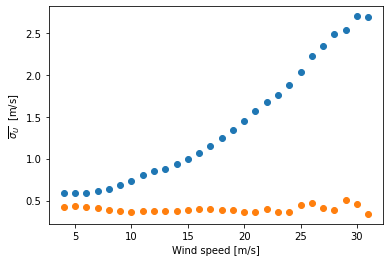

In [7]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
plt.xlabel("Wind speed [m/s]")
plt.ylabel(r"$\overline{\sigma_U}$  [m/s]")
plt.show()

In [8]:
pMu0 = np.polyfit(WspBinCentres, meanSigmaBinned,0)
pMu1 = np.polyfit(WspBinCentres, meanSigmaBinned,1)
pMu2 = np.polyfit(WspBinCentres, meanSigmaBinned,2)
pMsu0 = np.polyfit(WspBinCentres, stdSigmaBinned,0)

poly0 = np.poly1d(pMu0)
poly1 = np.poly1d(pMu1)
poly2 = np.poly1d(pMu2)
poly3 = np.poly1d(pMsu0)

SigmaSigmaRef = np.mean(stdSigmaBinned)
        
MuSigmaFunc = lambda u: poly2(u)
SigmaSigmaFunc = lambda u: SigmaSigmaRef * np.ones(u.shape)


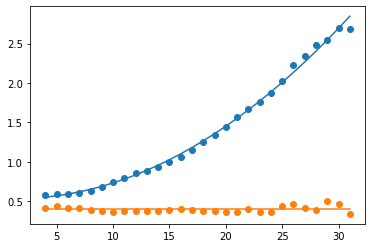

In [9]:
plt.scatter(WspBinCentres, meanSigmaBinned)
plt.scatter(WspBinCentres, stdSigmaBinned)
# plt.plot(WspBinCentres, poly0(WspBinCentres))
# plt.plot(WspBinCentres, poly1(WspBinCentres))
plt.plot(WspBinCentres, poly2(WspBinCentres))
plt.plot(WspBinCentres, poly3(WspBinCentres))
plt.show()

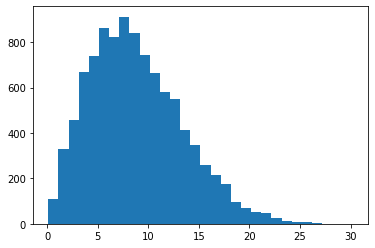

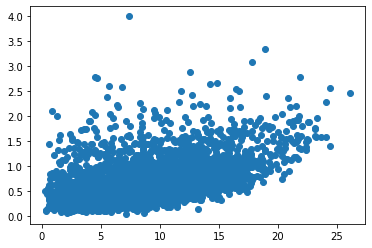

In [10]:
# Monte Carlo 
n = 10000

# Wind speed random sample
Urand = stats.weibull_min.ppf(np.random.randn(n), scale=A_weibull, c=k_weibull)
Urand = stats.weibull_min.rvs(scale=A_weibull, c=k_weibull, size=n)

# Turbulence random sample
def NormalDist(task,x,mu=0,sigma=1):
    import numpy as np
    if task == 0: # PDF
        y = (1.0/(sigma*np.sqrt(2.0*np.pi)))*np.exp(-((x - mu)**2)/(2.0*(sigma**2)))
    elif task == 1: # Cumulative
        from scipy.special import erf
        y = 0.5*(1.0 + erf((x - mu)/(sigma*np.sqrt(2))))
    elif task == 2: # Inverse
        from scipy.special import erfinv
        y = mu + sigma*np.sqrt(2)*erfinv(2*x - 1)        
    return y
# Helper function - lognormal distribution
def LogNormDist(task,x,mu,sigma):
    import numpy as np
    tol = 1e-16
    mu = np.asarray(mu)
    mu[mu<tol] = tol
    Eps   = np.sqrt(np.log( 1.0+(sigma/mu)**2 ) )
    Ksi   = np.log(mu)-0.5*Eps**2
    if task == 0: # PDF
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y = np.exp(-u*u/2.0)/(Eps*x*np.sqrt(2.0*np.pi))
    elif task == 1: # Cummulative
        x[x<=0] = 1e-8
        u =(np.log(x)-Ksi)/Eps
        y= NormalDist(1, u)
    elif task == 2: # Inverse
        y= np.exp(Ksi+Eps*NormalDist(2, x))
    
    return y

MuSigmaU = MuSigmaFunc(Urand)
SigmaSigmaU = SigmaSigmaFunc(Urand)
SigmaUrand = LogNormDist(2, np.random.randn(n), mu=MuSigmaU, sigma=SigmaSigmaU)
# SigmaSigmaUrand = stats.lognorm.ppf(np.random.randn(n), s=SigmaSigmaU)

plt.hist(Urand, 30)
plt.show()
plt.scatter(Urand, SigmaUrand)
plt.show()

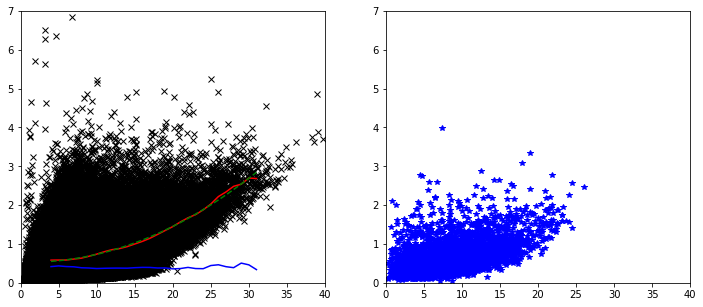

In [11]:
fig,ax = plt.subplots(1,2, figsize = (12,5))
ax[0].plot(filtered_data['Wsp'],filtered_data['sigmaWsp'],'xk')
ax[0].plot(WspBinCentres,meanSigmaBinned,'-r')
ax[0].plot(WspBinCentres,stdSigmaBinned,'-b')
ax[0].plot(WspBinCentres,MuSigmaFunc(WspBinCentres),'--g')
ax[0].set_xlim([0,40])
ax[0].set_ylim([0,7])
ax[1].plot(Urand,SigmaUrand,'*b')
ax[1].set_xlim([0,40])
ax[1].set_ylim([0,7])
plt.show()

# Task 2

In [12]:
yearss = pd.unique(filtered_data['Timestamp'].dt.year.values)

print(yearss)

alpha = 1-0.95
Nbootstrap = 1000

BootstrapMeans_stacked = np.zeros(1)

for iyear,year in enumerate(yearss): 
    
    boot2004 = filtered_data[filtered_data['Timestamp'].dt.year == year]
    print(year, len(boot2004))
    BootstrapSize = len(boot2004)

    BootstrapSample = np.random.choice(boot2004['Wsp'], size = (BootstrapSize, Nbootstrap))
#     BootstrapMeans_temp = np.sort(np.mean(BootstrapSample, axis=1))
    BootstrapMeans_temp = np.mean(BootstrapSample, axis=1)
#     print(BootstrapMeans_temp)
    # stack the BootstrapMeans_temp of each year vertically  
    # BootstrapMeans = np.sort(np.mean(BootstrapSample, axis=1))
    BootstrapMeans_stacked = np.concatenate((BootstrapMeans_stacked, BootstrapMeans_temp), axis=None)
    
print(BootstrapMeans_stacked)

# resort data
BootstrapMeans = np.sort(BootstrapMeans_stacked[1:])
print(BootstrapMeans, len(BootstrapMeans))


# Determine confidence intervals
Rlow = int(np.around(len(BootstrapMeans)*alpha/2))
Rhigh = int(np.around((1-alpha/2)*len(BootstrapMeans)))
print(Rlow, Rhigh)

CIn_B = BootstrapMeans[Rlow]
CIp_B = BootstrapMeans[Rhigh]

print('Confidence interval based on bootstrapping: [' + str(CIn_B) + ', ' + str(CIp_B) + ']')

# print(Nbootstrap)
# print(BootstrapSize)
# bootstrapsize 

[2004 2005 2006 2007 2008 2009 2010 2011 2012 2013]
2004 12994
2005 44659
2006 51442
2007 47837
2008 49906
2009 51371
2010 47392
2011 47761
2012 48768
2013 27622
[ 0.        10.0673743 10.333179  ...  7.5111176  7.7766886  7.5828865]
[ 7.1341611  7.164513   7.1677496 ... 10.6280113 10.6545237 10.6711698] 429752
10744 419008
Confidence interval based on bootstrapping: [7.6043415, 9.9433371]


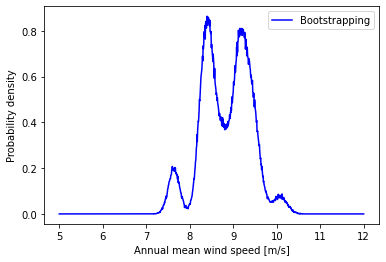

In [13]:
Ubins = np.linspace(5,12,1000)

# pdf_N = stats.norm.pdf(Ubins,Umean,Ustd/np.sqrt(n))
# dU = Ubins[1]-Ubins[0] # Scaling factor for the t-pdf to make sure we get a valid pdf for every bin spacing
# pdf_T = (1/np.sqrt(dU))*stats.t.pdf((Ubins - Umean)/(Ustd/np.sqrt(n)), n - 1)

# Generating an empirical pdf from the bootstrap sample
BootstrapHist = np.histogram(BootstrapMeans,bins = Ubins)
BootstrapDist = stats.rv_histogram(BootstrapHist)
pdf_B = BootstrapDist.pdf(Ubins)

fig1, ax1 = plt.subplots()
# p11 = ax1.plot(Ubins,pdf_N,'--r', label = 'Normal')
p12 = ax1.plot(Ubins,pdf_B,'-b', label = 'Bootstrapping')
# p13 = ax1.plot(Ubins,pdf_T,'-k', label = 'T-dist')
plt.xlabel('Annual mean wind speed [m/s]')
plt.ylabel('Probability density')
plt.legend()

plt.show()

# Task 3 : Surrogate model

In [14]:
InputData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'InputVariables')
InputData = InputData.set_index('Sample_No', drop = False)
InputData.head()

,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,,
1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008


In [15]:
TargetData = pd.read_excel(data_path + 'ML_ExampleDataSet.xlsx', 'LoadResults')
TargetData = TargetData.set_index('PointNo', drop = False)
TargetData.head()

,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
PointNo,,,,,,,,,
1,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
2,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
3,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
4,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
5,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417


In [16]:
MergedData = pd.merge(InputData, TargetData, how='inner', on=[InputData['Sample_No'], TargetData['PointNo']])
MergedData

,key_0,key_1,Sample_No,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi,PointNo,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
0,1,1,1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000,1,747.561872,200.666288,6708.717789,8861.885588,1229.076579,63.457528,4253.317748,15006.726860
1,2,2,2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217,2,3556.031457,676.339081,16692.647572,6329.099515,6952.985180,1354.995442,10409.290476,16289.414152
2,3,3,3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593,3,4667.540374,1337.390736,47357.937376,31829.036012,10138.140146,2804.304402,13755.148891,16535.154243
3,4,4,4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810,4,2468.757942,242.431345,8130.594535,3871.907737,4216.051060,250.684887,12307.312889,16500.098901
4,5,5,5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008,5,3261.845253,1035.420007,36971.924749,26395.063750,6630.640795,2256.349794,13128.763279,16207.306417
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9975,9996,9996,9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259,9996,6564.464434,858.778565,28091.651088,13608.101268,14513.682848,1147.107370,21518.552601,16773.394758
9976,9997,9997,9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315,9997,2047.344061,385.287048,22144.619831,16663.888804,3024.747490,676.705869,3891.227781,15376.750042
9977,9998,9998,9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441,9998,5958.074303,646.040924,20715.173212,7395.479028,11789.005321,740.922800,19334.780023,17384.510924
9978,9999,9999,9999,9.298782,2.830030,0.709374,84.883531,4.851649,-4.457392,9999,6631.147297,1463.861197,42145.162750,21430.048990,15017.124218,3076.452821,24014.999552,18408.246843


In [17]:
%%timeit -n 10
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])

4.31 ms ± 679 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [18]:
AllInputData = InputData.where(InputData['Sample_No']==TargetData['PointNo'])
AllTargetData = TargetData.where(TargetData['PointNo']==InputData['Sample_No'])
AllInputData.drop(columns = 'Sample_No', inplace = True)
AllTargetData.drop(columns = 'PointNo', inplace = True)
nsamples = AllInputData['U'].count() # Find the total number of data points in the data frame
FeatureNames = AllInputData.columns.values
DependentVariableNames = AllTargetData.columns.values
print('Feature names: ', FeatureNames)
print('Dependent variable names: ', DependentVariableNames)
print(AllInputData.iloc[:,0].values)
AllInputData

Feature names:  ['U' 'SigmaU' 'Alpha' 'MannL' 'MannGamma' 'VeerDeltaPhi']
Dependent variable names:  ['Tower_top_fore_aft_M_x' 'Tower_top_side2side_M_y'
 'Tower_base_fore_aft_M_x' 'Tower_base_side2side_M_y' 'Yaw_moment_M_z'
 'Main_shaft_torsion_M_z' 'Blade_root_flapwise_M_x'
 'Blade_root_edgewise_M_y']
[ 4.         10.1507576   6.81346652 ... 13.32617204  9.2987816
 19.89821019]


,U,SigmaU,Alpha,MannL,MannGamma,VeerDeltaPhi
Sample_No,,,,,,
1,4.000000,0.100000,-0.650000,7.500000,1.000000,-22.250000
2,10.150758,1.208656,-0.139692,48.470634,1.363636,-4.771217
3,6.813467,2.261463,0.129071,88.379710,1.727273,-3.981593
4,14.500000,0.704260,0.332996,122.142857,2.090909,0.162810
5,5.356299,1.776301,1.147039,160.357143,2.454545,2.639008
...,...,...,...,...,...,...
9996,15.991490,2.934493,-0.031461,271.543107,3.760740,14.080259
9997,6.111425,0.948102,0.176589,8.454959,4.124377,41.866315
9998,13.326172,2.043617,0.345013,46.669245,4.488013,-6.197441


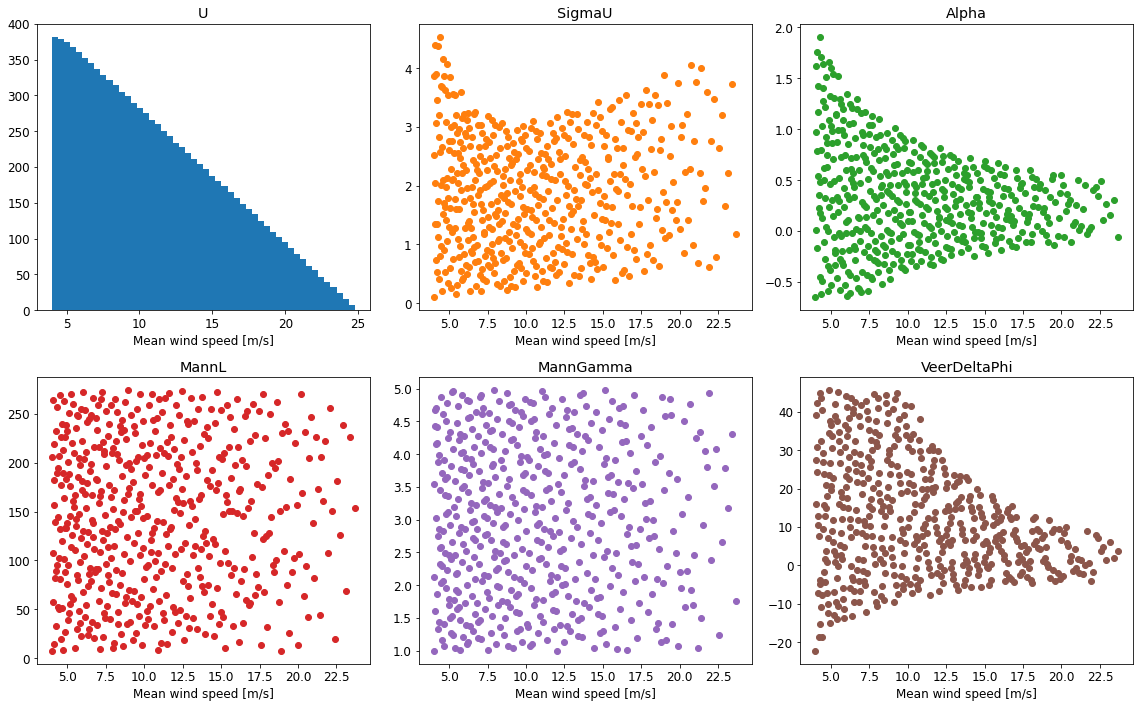

In [19]:
import matplotlib.pyplot as plt
nplotpoints = 500
plt.rc('font', size=12) 
fig1,axs1 = plt.subplots(2,3,figsize = (16,10))
plt.setp(axs1,xlabel = "Mean wind speed [m/s]")
plt.setp(axs1[0,0], title = FeatureNames[0])
plt.setp(axs1[0,1], title = FeatureNames[1])
plt.setp(axs1[0,2], title = FeatureNames[2])
plt.setp(axs1[1,0], title = FeatureNames[3])
plt.setp(axs1[1,1], title = FeatureNames[4])
plt.setp(axs1[1,2], title = FeatureNames[5])
axs1[0,0].hist(AllInputData.iloc[:,0],50,color = 'C0')
axs1[0,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,1],'o',color = 'C1')
axs1[0,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,2],'o',color = 'C2')
axs1[1,0].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,3],'o',color = 'C3')
axs1[1,1].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,4],'o',color = 'C4')
axs1[1,2].plot(AllInputData.iloc[0:nplotpoints,0],AllInputData.iloc[0:nplotpoints,5],'o',color = 'C5')
plt.tight_layout()             
plt.show()

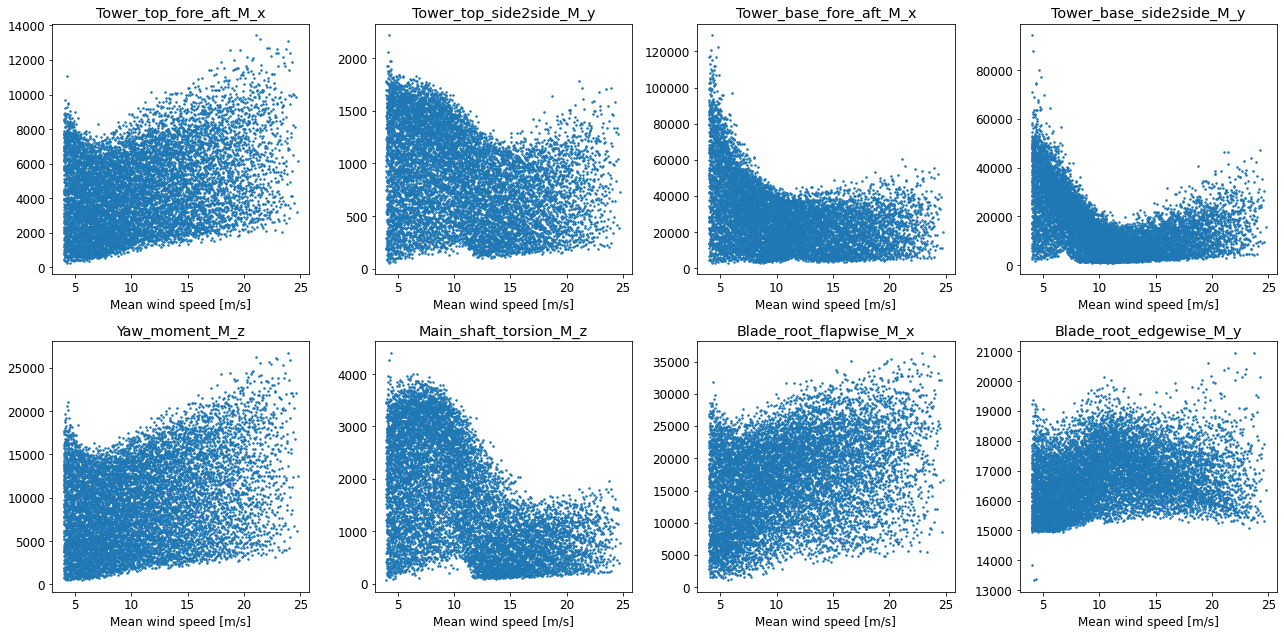

In [20]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Mean wind speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

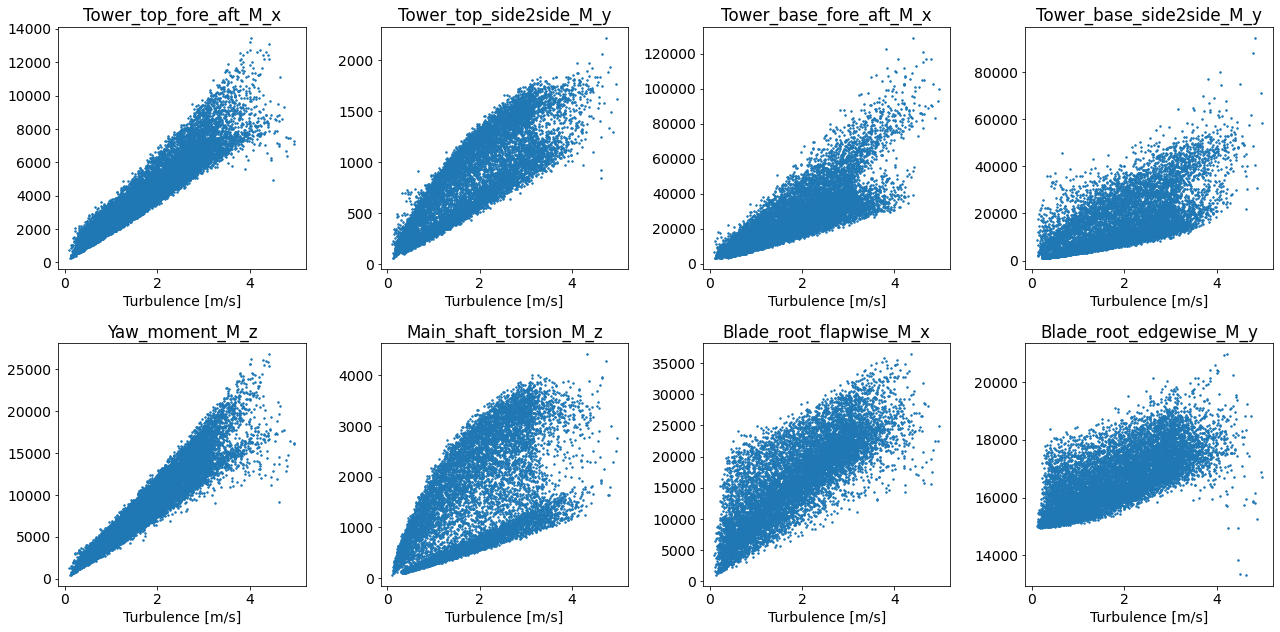

In [48]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3)
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.show()

In [65]:
# Building a design matrix for a polynomial of 3rd order
def DesignMatrixO3(X):
    ndim = X.shape[1] 
    npoints = X.shape[0]
    m = int(((ndim-1)/2)*ndim)
    Xmatrix = np.zeros((npoints,3*ndim + 3*m + 1))
    columncount = 0
    Xmatrix[:,columncount] = np.ones(npoints)
    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]

    for i in range(ndim -1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*X[:,j]

    for i in range(ndim):
        columncount+= 1
        Xmatrix[:,columncount] = X[:,i]**2

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = (X[:,i]**2)*X[:,j]

    for i in range(ndim-1):
        for j in range(i+1,ndim):
            columncount+= 1
            Xmatrix[:,columncount] = X[:,i]*(X[:,j]**2)

    for i in range(ndim):
        columncount+=1
        Xmatrix[:,columncount] = X[:,i]**3
    return Xmatrix


def PredictPolyO3(X,Alsq):
    Xmatrix = DesignMatrixO3(X)
    Y = np.dot(Xmatrix,Alsq)
    return Y


def GetPredictedData(AllTargetData, Xmatrix):
    
    
    Y_Mx_pred = {}
    
    # print(AllTargetData.columns.values)
    for icol,col in enumerate(AllTargetData.columns.values):
    
        Y_Mx = AllTargetData['Tower_base_fore_aft_M_x']
        Y_Mx = AllTargetData[f'{col}']

        # Determine beta
        XX = np.dot(Xmatrix.T, Xmatrix)
        XY = np.dot(Xmatrix.T, Y_Mx)
        beta = np.linalg.lstsq(XX, XY, rcond=None)
        beta = beta[0]

        # Calculate predicted data and store      
        Y_Mx_pred[f'{col}'] = np.dot(Xmatrix, beta)
    
    # Create a dataframe with all the predicted data     
    AllPredData = pd.DataFrame(Y_Mx_pred)
    
    return AllPredData

In [67]:
# Construct coefficient matrix (Xmatrix)
Xmatrix = DesignMatrixO3(AllInputData.values)

AllPredData = GetPredictedData(AllTargetData, Xmatrix)

AllPredData.head()

,Tower_top_fore_aft_M_x,Tower_top_side2side_M_y,Tower_base_fore_aft_M_x,Tower_base_side2side_M_y,Yaw_moment_M_z,Main_shaft_torsion_M_z,Blade_root_flapwise_M_x,Blade_root_edgewise_M_y
0,308.229663,-97.191850,12395.122072,9826.745389,-7.673778,-503.436981,-2075.215108,6847.838849
1,3351.242486,430.366504,16781.487160,8831.420213,6542.993831,528.987474,8574.834871,13246.755104
2,4811.701415,1136.415676,39043.251690,22192.371567,10124.461251,2376.761863,14468.355150,15577.534358
3,2315.955317,202.659816,8179.088720,2427.873941,4224.764379,145.188651,12274.158123,16618.670883
4,3403.848701,1094.923977,33952.138176,23729.983452,7124.076714,2479.968797,14686.544669,16451.522627


### Dependence vs mean wind speed

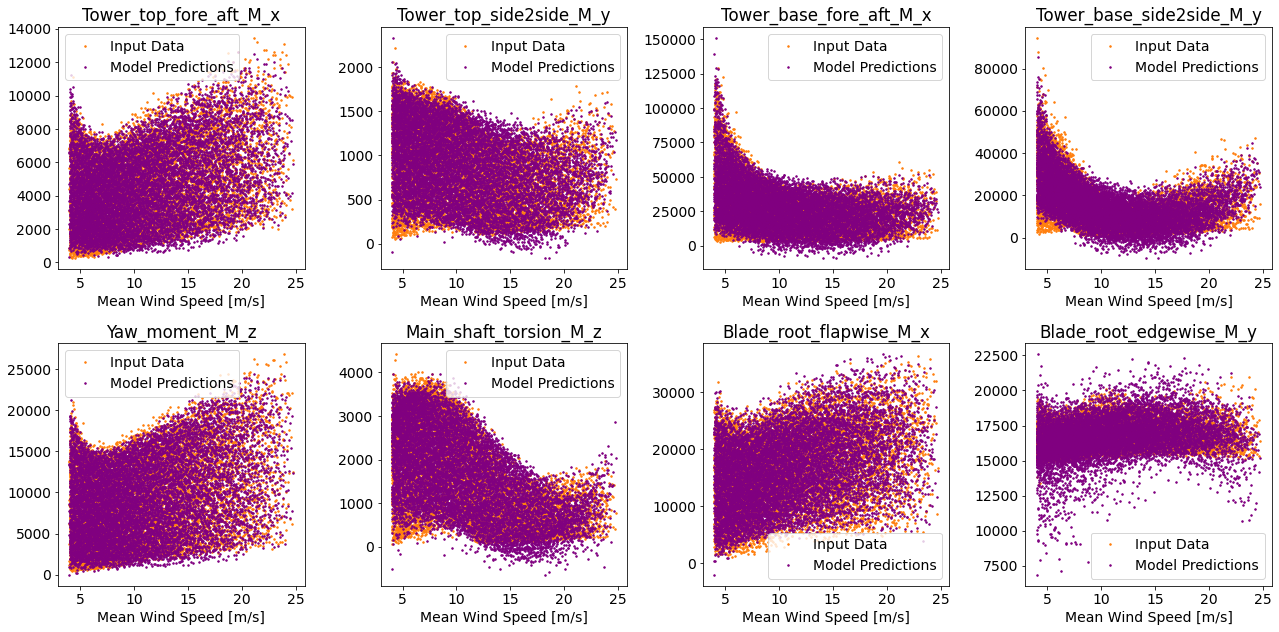

In [83]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.U,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.U,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.legend(['Input Data', 'Model Predictions'])
    plt.xlabel('Mean Wind Speed [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.savefig(results_path + 'task3/task3_MWS.pdf')
plt.show()
    

### Dependence vs Turbulence ($\sigma_U$)

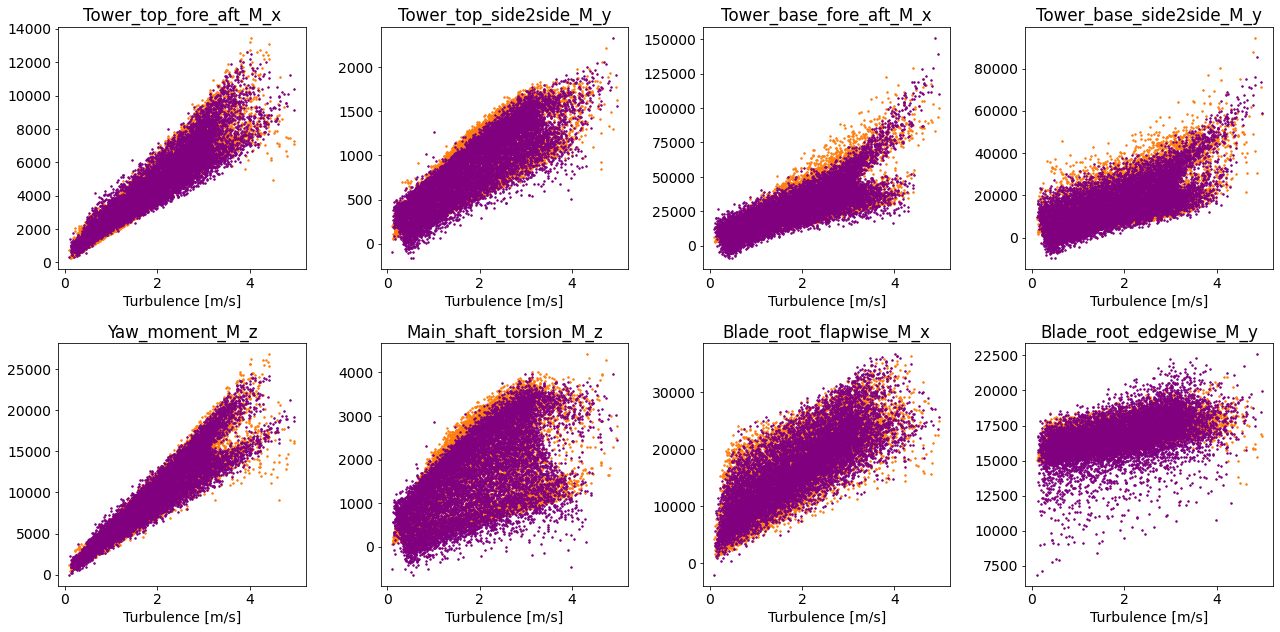

In [84]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.SigmaU,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.SigmaU,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Turbulence [m/s]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.savefig(results_path + 'task3/task3_SigmaU.pdf')
plt.show()

### Dependence vs shear exponent ($\alpha$)

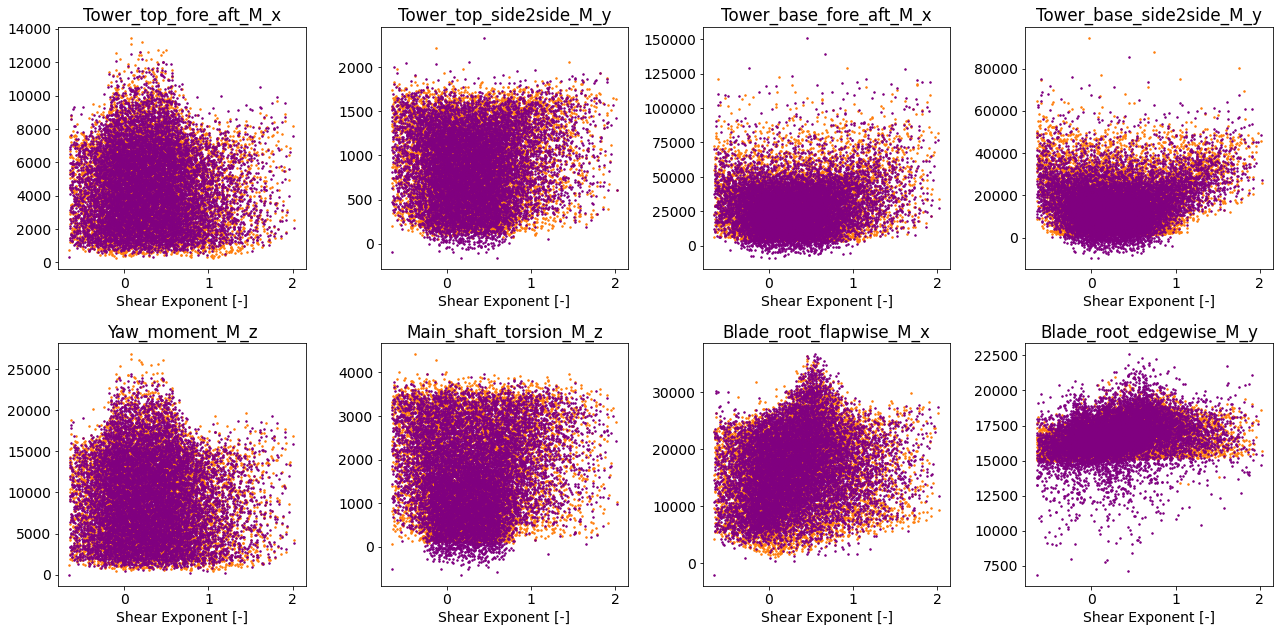

In [85]:
fig2 = plt.figure(2, figsize = (18,9))

for idep, dep in enumerate(DependentVariableNames):
    axi = fig2.add_subplot(2,4,idep+1)
    plt.title(DependentVariableNames[idep])
    plt.plot(AllInputData.Alpha,AllTargetData.iloc[:,idep],'.',markersize = 3, color = 'C1')
    plt.plot(AllInputData.Alpha,AllPredData.iloc[:,idep],'.',markersize = 3, color = 'purple')
    plt.xlabel('Shear Exponent [-]')
    #plt.ylabel(DependentVariableNames[i])
plt.tight_layout()
plt.savefig(results_path + 'task3/task3_Shearexp.pdf')
plt.show()

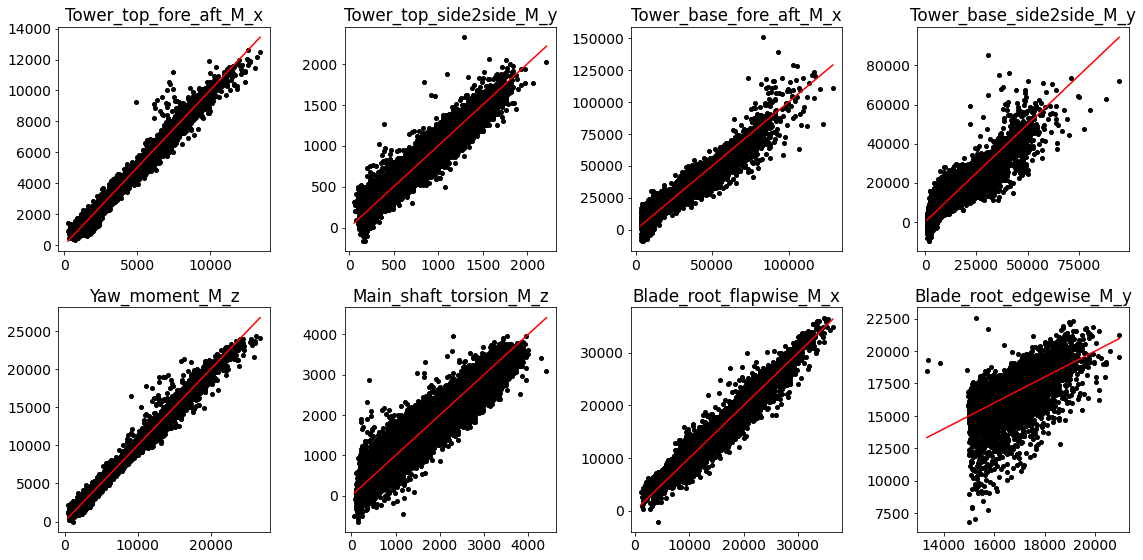

In [102]:
plt.rc('font', size=14) 
fig2a,axs2a = plt.subplots(2,4,figsize = (16,8))

for icol,col in enumerate(AllPredData):
    if icol <= 3:
        row=0
    else:
        row=1
        icol = icol-4
        
    axs2a[row,icol].plot(AllTargetData[f'{col}'],AllPredData[f'{col}'],'ok',markersize = 4)
    axs2a[row,icol].plot(np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),\
         np.array([np.min(AllTargetData[f'{col}']), np.max(AllTargetData[f'{col}'])]),'-r')
    axs2a[row,icol].set_title(f"{col}")
    
# axs2a[1].legend(['Point-to-point comparisons','1:1 relation'])
plt.tight_layout()       
plt.savefig(results_path + 'task3/pp_comparison.png')
plt.show()

In [103]:
for icol,col in enumerate(AllPredData):
    
    Rsq_poly = (np.corrcoef(AllTargetData[f'{col}'],AllPredData[f'{col}'])[0,1])**2
    RMSE_poly = np.sqrt( np.mean((AllTargetData[f'{col}'] - AllPredData[f'{col}'])**2))
    print(f"\n{col}")
    print('R-square of polynomial model: ' + str(Rsq_poly))
    print('RMSE of polynomial model: ' + str(RMSE_poly))


Tower_top_fore_aft_M_x
R-square of polynomial model: 0.9780594696956738
RMSE of polynomial model: 3271.1287767859603

Tower_top_side2side_M_y
R-square of polynomial model: 0.9165201415106744
RMSE of polynomial model: 598.8295178881091

Tower_base_fore_aft_M_x
R-square of polynomial model: 0.9188387212394608
RMSE of polynomial model: 24848.188449527548

Tower_base_side2side_M_y
R-square of polynomial model: 0.832544739201432
RMSE of polynomial model: 15897.019890019483

Yaw_moment_M_z
R-square of polynomial model: 0.9840142868627316
RMSE of polynomial model: 6999.344281469442

Main_shaft_torsion_M_z
R-square of polynomial model: 0.8853027374091798
RMSE of polynomial model: 1374.5546415410138

Blade_root_flapwise_M_x
R-square of polynomial model: 0.9438148053469956
RMSE of polynomial model: 9413.046776504068

Blade_root_edgewise_M_y
R-square of polynomial model: 0.432777306119326
RMSE of polynomial model: 1787.0656009313443
